In [51]:
# IMPORTS
import numpy as np
import pandas as pd
import scipy
import matplotlib
import seaborn as sns
import sklearn
import tensorflow
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import time
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from enum import Enum
import os
import requests

# Global variables and helper functions

In [52]:
# Global values used in this notebook:
tv_dataset = 'char'        # Can be: image, digit, char
eeg_origin = 'PerceiveLab'  # Can be: ThoughtViz, MindBig, PerceiveLab
num_classes = 10            # Can be: 10(ThoughtViz, MindBig), 40(PerceiveLab)

# EEG channels used in ThoughtViz
channels_arr = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

# Sliding window
window_size = 32
overlap = 8
step_size = window_size - overlap

In [53]:
def get_current_time():
    # Saving model - using time as unique identifier for name
    t = time.localtime()
    current_time = time.strftime("%D_%H_%M_%S", t)

    #make the day format have a - instead of /
    current_time = current_time.replace("/","_")

    #time as string
    timeString = str(current_time)

    return timeString

def apply_sliding_window(data, window_size, step_size, selected_channels):
    num_samples, _, length, channels = data.shape
    num_windows = (length - window_size) // step_size
    num_selected_channels = len(selected_channels)
    new_shape = (num_samples * num_windows, num_selected_channels, window_size, channels)
    windows = np.zeros(new_shape)

    for i in range(num_samples):
        for j in range(num_windows):
            start = j * step_size
            end = start + window_size
            windows[i * num_windows + j, :, :, :] = data[i, selected_channels, start:end, :]
    
    return windows

def shuffle_two_arrays_identically(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def z_score_normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std

# ThoughtViz dataset:

Data found in the outer 'eeg' folder are the images used for the EEG classifier. This includes both training data as well as test data.
- 23 participants, each seeing 10 classes of each data type (char, digit, image) for 10 seconds, recorded with 14 channels at 128Hz sampling rate per channel (Emotiv EPOC+ device).

Data found in the outer 'images' folder are the images used for training the generator. Thus, these are not the images seen by the participants when creating the EEG data.

In [54]:
# Load pkl file
with open(f'eeg/{tv_dataset}/data.pkl', 'rb') as f:
    tv_eeg_data  = pickle.load(f, encoding='latin1')

In [55]:
# Define classes
IMAGE_CLASSES = {'Apple': 0, 'Car': 1, 'Dog': 2, 'Gold': 3, 'Mobile': 4, 'Rose': 5, "Scooter": 6, 'Tiger': 7, 'Wallet': 8, 'Watch': 9}
CHARACTER_CLASSES = {'A': 0, 'C': 1, 'F': 2, 'H': 3, 'J': 4, 'M': 5, 'P': 6, 'S': 7, 'T': 8, 'Y': 9}

# Get keys
keysList = list(tv_eeg_data.keys())
print('Keys in dataset:', keysList)

# Display data
print('Data shapes:')
print('x_train:', tv_eeg_data['x_train'].shape)
print('y_train:', tv_eeg_data['y_train'].shape)
print('x_test:', tv_eeg_data['x_test'].shape)
print('y_test:', tv_eeg_data['y_test'].shape)

print('Example values of first time sliding window:')
display(pd.DataFrame(np.squeeze(tv_eeg_data['x_train'][0])))
display(pd.DataFrame(np.squeeze(tv_eeg_data['y_train'])))

Keys in dataset: ['x_test', 'x_train', 'y_train', 'y_test']
Data shapes:
x_train: (45083, 14, 32, 1)
y_train: (45083, 10)
x_test: (5642, 14, 32, 1)
y_test: (5642, 10)
Example values of first time sliding window:


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,4258.461538,4228.717949,4213.333333,4232.307692,4220.000000,4248.717949,4230.769231,4226.153846,4244.102564,4212.820513,...,4227.179487,4253.846154,4220.000000,4227.692308,4232.307692,4202.564103,4224.615385,4204.102564,4211.794872,4220.512821
1,4238.461538,4228.205128,4203.076923,4215.384615,4214.358974,4225.641026,4229.743590,4213.846154,4217.435897,4206.666667,...,4221.538462,4232.820513,4227.692308,4218.461538,4218.461538,4204.615385,4212.307692,4203.589744,4200.512821,4216.410256
2,4244.615385,4223.589744,4218.974359,4223.589744,4225.128205,4240.000000,4224.102564,4230.769231,4234.358974,4221.538462,...,4230.256410,4245.128205,4224.615385,4232.307692,4222.564103,4206.666667,4216.410256,4208.205128,4221.538462,4214.871795
3,4262.564103,4188.205128,4199.487179,4258.461538,4200.512821,4285.641026,4205.128205,4191.794872,4254.871795,4180.000000,...,4175.384615,4274.871795,4209.230769,4256.923077,4239.487179,4164.102564,4261.538462,4184.102564,4217.948718,4250.256410
4,4237.948718,4223.076923,4232.307692,4237.435897,4213.333333,4232.820513,4212.820513,4221.538462,4242.051282,4231.794872,...,4230.256410,4246.153846,4214.871795,4233.333333,4228.717949,4209.743590,4240.000000,4229.743590,4237.948718,4226.153846
5,4242.564103,4231.794872,4237.435897,4241.025641,4216.923077,4236.410256,4221.025641,4228.717949,4245.641026,4228.717949,...,4233.846154,4248.205128,4215.384615,4229.743590,4228.717949,4211.794872,4239.487179,4227.692308,4237.948718,4230.256410
6,4225.128205,4226.666667,4224.102564,4231.282051,4241.538462,4226.153846,4229.743590,4229.743590,4221.025641,4225.641026,...,4245.641026,4234.358974,4222.564103,4215.384615,4218.974359,4208.205128,4193.846154,4212.820513,4218.461538,4224.102564
7,4222.051282,4234.358974,4228.205128,4223.589744,4234.871795,4222.051282,4217.948718,4213.846154,4211.794872,4221.538462,...,4249.743590,4229.743590,4215.897436,4215.384615,4216.410256,4201.025641,4197.948718,4231.794872,4234.871795,4224.615385
8,4236.410256,4232.820513,4233.333333,4234.871795,4231.282051,4233.846154,4233.333333,4235.897436,4235.897436,4231.282051,...,4229.743590,4232.820513,4232.307692,4234.358974,4232.820513,4232.820513,4236.923077,4230.769231,4230.256410,4233.846154
9,4235.384615,4232.307692,4233.333333,4234.871795,4232.820513,4234.871795,4235.897436,4236.410256,4234.871795,4233.333333,...,4234.871795,4234.871795,4229.743590,4230.769231,4232.820513,4232.820513,4233.333333,4232.820513,4233.846154,4232.820513


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
45078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45079,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
45080,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45081,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# Z-score normalize Thoughtviz's x data
x_train_norm = z_score_normalize(tv_eeg_data['x_train'])
x_test_norm = z_score_normalize(tv_eeg_data['x_test'])

# Print
print('Z-score normalized data:')
print('x_train:', x_train_norm.shape)
print('x_test:', x_test_norm.shape)

print('Example values of first time sliding window:')
display(pd.DataFrame(np.squeeze(x_train_norm[0])))
display(pd.DataFrame(np.squeeze(x_test_norm[0])))

Z-score normalized data:
x_train: (45083, 14, 32, 1)
x_test: (5642, 14, 32, 1)
Example values of first time sliding window:


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.289979,0.014540,-0.127929,0.047783,-0.066192,0.199749,0.033536,-0.009205,0.157009,-0.132678,...,0.000293,0.247239,-0.066192,0.005042,0.047783,-0.227657,-0.023452,-0.213410,-0.142176,-0.061443
1,0.104770,0.009791,-0.222908,-0.108933,-0.118431,-0.013954,0.024038,-0.123180,-0.089937,-0.189665,...,-0.051945,0.052532,0.005042,-0.080439,-0.080439,-0.208661,-0.137427,-0.218159,-0.246653,-0.099435
2,0.161758,-0.032950,-0.075690,-0.032950,-0.018703,0.119017,-0.028201,0.033536,0.066778,-0.051945,...,0.028787,0.166507,-0.023452,0.047783,-0.042447,-0.189665,-0.099435,-0.175418,-0.051945,-0.113682
3,0.327971,-0.360627,-0.256150,0.289979,-0.246653,0.541674,-0.203912,-0.327385,0.256737,-0.436611,...,-0.479351,0.441946,-0.165920,0.275733,0.114268,-0.583828,0.318473,-0.398619,-0.085188,0.213996
4,0.100021,-0.037699,0.047783,0.095272,-0.127929,0.052532,-0.132678,-0.051945,0.138013,0.043034,...,0.028787,0.176004,-0.113682,0.057281,0.014540,-0.161171,0.119017,0.024038,0.100021,-0.009205
5,0.142762,0.043034,0.095272,0.128515,-0.094686,0.085774,-0.056694,0.014540,0.171256,0.014540,...,0.062030,0.195000,-0.108933,0.024038,0.014540,-0.142176,0.114268,0.005042,0.100021,0.028787
6,-0.018703,-0.004456,-0.028201,0.038285,0.133264,-0.009205,0.024038,0.024038,-0.056694,-0.013954,...,0.171256,0.066778,-0.042447,-0.108933,-0.075690,-0.175418,-0.308389,-0.132678,-0.080439,-0.028201
7,-0.047196,0.066778,0.009791,-0.032950,0.071527,-0.047196,-0.085188,-0.123180,-0.142176,-0.051945,...,0.209247,0.024038,-0.104184,-0.108933,-0.099435,-0.241904,-0.270397,0.043034,0.071527,-0.023452
8,0.085774,0.052532,0.057281,0.071527,0.038285,0.062030,0.057281,0.081025,0.081025,0.038285,...,0.024038,0.052532,0.047783,0.066778,0.052532,0.052532,0.090523,0.033536,0.028787,0.062030
9,0.076276,0.047783,0.057281,0.071527,0.052532,0.071527,0.081025,0.085774,0.071527,0.057281,...,0.071527,0.071527,0.024038,0.033536,0.052532,0.052532,0.057281,0.052532,0.062030,0.052532


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.106664,-0.030310,-0.021327,-0.115647,-0.043785,0.014604,0.046044,-0.021327,-0.070733,0.032570,...,0.131381,0.023587,0.140364,0.189770,0.230192,0.324512,0.288581,0.284089,0.230192,0.252649
1,-0.102173,0.023587,0.014604,-0.088699,-0.048276,-0.003362,0.028078,-0.075225,-0.142596,-0.007853,...,0.180787,0.122398,0.185278,0.131381,0.140364,0.261632,0.279598,0.270615,0.185278,0.194261
2,-0.057259,0.023587,0.028078,-0.088699,-0.039293,0.041553,0.086467,0.005621,-0.039293,0.086467,...,0.135872,0.055027,0.144855,0.167312,0.203244,0.297564,0.297564,0.288581,0.212227,0.266124
3,0.010113,0.001130,0.046044,-0.025819,-0.066242,0.126890,0.072993,0.019095,0.001130,-0.021327,...,0.122398,0.171804,0.113415,0.171804,0.131381,0.162821,0.261632,0.135872,0.176295,0.189770
4,0.077484,-0.034802,0.041553,0.072993,-0.039293,0.081975,-0.003362,0.046044,0.068501,-0.016836,...,0.019095,0.095450,-0.052767,0.050535,0.014604,-0.021327,0.081975,-0.039293,0.077484,0.077484
5,0.023587,-0.007853,0.041553,0.023587,-0.052767,0.014604,-0.007853,-0.039293,0.005621,0.023587,...,0.019095,0.077484,0.055027,0.064010,0.019095,0.014604,0.086467,0.032570,0.023587,0.028078
6,0.059518,0.117907,0.099941,0.014604,0.032570,0.014604,0.028078,0.041553,0.086467,0.257141,...,0.275107,0.234684,0.288581,0.185278,0.090958,0.108924,0.108924,0.149347,0.090958,0.122398
7,-0.093190,0.059518,0.185278,0.104432,0.099941,0.099941,0.090958,-0.003362,0.014604,0.230192,...,0.400866,0.297564,0.261632,0.162821,0.144855,0.207735,0.153838,0.131381,-0.012345,-0.156070
8,-0.102173,0.041553,0.122398,0.055027,0.077484,0.081975,0.068501,-0.021327,-0.048276,0.095450,...,0.185278,0.104432,0.135872,0.086467,0.072993,0.122398,0.095450,0.113415,0.023587,-0.084207
9,0.037061,0.037061,0.041553,0.041553,0.041553,0.046044,0.041553,0.037061,0.037061,0.046044,...,0.041553,0.041553,0.046044,0.046044,0.037061,0.041553,0.041553,0.041553,0.041553,0.041553


# MindBigData dataset

In [57]:
# Install MindBigData dataset

# URLs
train_url = "https://huggingface.co/datasets/DavidVivancos/MindBigData2022_VisMNIST_Cap64/resolve/main/train.csv"
test_url = "https://huggingface.co/datasets/DavidVivancos/MindBigData2022_VisMNIST_Cap64/resolve/main/test.csv"

def download_file(url, file_path):
    # Check if the file already exists
    if os.path.exists(file_path):
        print(f"The file {file_path} already exists. Skipping download.")
        return

    # Create directory if it does not exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Download and save the file
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {file_path}")
    else:
        print(f"Failed to download {file_path}. Status code: {response.status_code}")

# Downloading the train.csv and test.csv files
download_file(train_url, "./eeg/MindBig/train.csv")
download_file(test_url, "./eeg/MindBig/test.csv")

The file ./eeg/MindBig/train.csv already exists. Skipping download.
The file ./eeg/MindBig/test.csv already exists. Skipping download.


### Load and setup train data dictionary

In [58]:
# Load train data
mb_train_df = pd.read_csv('./eeg/MindBig/train.csv')

# Remove blank screen EEG recordings from data (cut out -1 in label column)
mb_train_df = mb_train_df[mb_train_df['label'] != -1]

# Create dictionary to seperate labels (outputs) from eeg data (inputs)
# (also to have the same EEG format as ThoughtViz)
mb_train_dict = {
    'labels': mb_train_df.iloc[:, 0],  # First column for labels
    'image_data': mb_train_df.iloc[:, 1:785],  # Next 784 columns for image data
    'eeg_data': mb_train_df.iloc[:, 785:].values.reshape((929, 64, 400, 1))  # Remaining columns for EEG data
}

### Load and setup test data dictionary

In [59]:
# Load test data
mb_test_df = pd.read_csv('./eeg/MindBig/test.csv')

# Remove blank screen EEG recordings from data (cut out -1 in label column)
mb_test_df = mb_test_df[mb_test_df['label'] != -1]

# Create dictionary to seperate labels (outputs) from eeg data (inputs)
# (also to have the same EEG format as ThoughtViz)
mb_test_dict = {
    'labels': mb_test_df.iloc[:, 0],  # First column for labels
    'image_data': mb_test_df.iloc[:, 1:785],  # Next 784 columns for image data
    'eeg_data': mb_test_df.iloc[:, 785:].values.reshape((237, 64, 400, 1))  # Remaining columns for EEG data
}

mb_test_dict['eeg_data'].shape

(237, 64, 400, 1)

### Reformatting to fit ThoughtViz data

#### Extract channel indices

In [60]:
# String of channel order taken from MindBigData https://mindbigdata.com/opendb/visualmnist.html
mb_channels_str = "FP1, FPz, FP2, AF3, AFz, AF4, F7, F5, F3, F1, Fz, F2, F4, F6, F8, FT7, FC5, FC3, FC1, FCz, FC2, FC4, FC6, FT8, T7, C5, C3, C1, Cz, CCPz, C2, C4, C6, T8, TP7, CP5, CP3, CP1, CPz, CP2, CP4, CP6, TP8, P7, P5, P3, P1, Pz, P2, P4, P6, P8, PO7, PO5, PO3, POz, PO4, PO6, PO8, CB1, O1, Oz, O2, CB2"
mb_channels = mb_channels_str.split(", ")
mb_channels_indices = [mb_channels.index(ch) for ch in channels_arr]

#### Apply sliding window and modify remaining data to match

In [61]:
# Modifying training data
if len(mb_train_dict['eeg_data'][0]) == 64:
    mb_train_dict['labels'] = np.repeat(mb_train_dict['labels'], 15)
    mb_train_dict['image_data'] = np.repeat(mb_train_dict['image_data'], 15)
    mb_train_dict['eeg_data'] = apply_sliding_window(mb_train_dict['eeg_data'], window_size, step_size, mb_channels_indices)

# Modifying test data
if len(mb_test_dict['eeg_data'][0]) == 64:
    mb_test_dict['labels'] = np.repeat(mb_test_dict['labels'], 15)
    mb_test_dict['image_data'] = np.repeat(mb_test_dict['image_data'], 15)
    mb_test_dict['eeg_data'] = apply_sliding_window(mb_test_dict['eeg_data'], window_size, step_size, mb_channels_indices)

print(mb_train_dict['eeg_data'].shape)
print(mb_test_dict['eeg_data'].shape)

(13935, 14, 32, 1)
(3555, 14, 32, 1)


#### Apply Z-score normalization

In [62]:
mb_train_dict['eeg_data'] = z_score_normalize(mb_train_dict['eeg_data'])
mb_test_dict['eeg_data'] = z_score_normalize(mb_test_dict['eeg_data'])

# PeRCeiVe dataset

In [63]:
# Load train data
prcv_data = torch.load('./eeg/PeRCeiVe/eeg_5_95_std.pth')

In [64]:
# Analyze data shapes
print(prcv_data.keys())
print(len(prcv_data['images']))
print(len(prcv_data['dataset']))
print(prcv_data['dataset'][0]['eeg'].shape)
print(prcv_data['dataset'][0])

dict_keys(['dataset', 'labels', 'images'])
1996
11965
torch.Size([128, 500])
{'eeg': tensor([[-0.0098,  0.0195,  0.0620,  ...,  0.0638,  0.0120, -0.0118],
        [-0.0045,  0.1303,  0.2673,  ...,  0.0894,  0.0342, -0.0082],
        [ 0.0215, -0.2017, -0.4305,  ..., -0.2022, -0.0940,  0.0188],
        ...,
        [ 0.0160,  0.0707,  0.1005,  ...,  0.2066,  0.1156,  0.0036],
        [-0.0046, -0.0084, -0.0119,  ...,  0.0007, -0.0026, -0.0053],
        [ 0.0040,  0.0419,  0.0665,  ...,  0.0765,  0.0309, -0.0063]]), 'image': 0, 'label': 10, 'subject': 4}


### Reformatting to fit ThoughtViz data

#### Setup eeg data

In [65]:
data = prcv_data['dataset']

processed_data = []

for record in data:
    if record['label'] <= 9:
        eeg_array = record['eeg'].numpy()  # Convert tensor to numpy array, if it's not already

        # Ensure the array has more than 460 samples
        if eeg_array.shape[1] > 460:
            # Slice the array to keep 440 samples, discarding the first 20
            truncated_array = eeg_array[:, 20:460]

            # Add an extra dimension
            truncated_array = truncated_array[..., np.newaxis]

            processed_data.append(truncated_array)

# Convert the list of arrays to a numpy array
prcv_eeg = np.array(processed_data)

# Split into training and test
prcv_train_eeg, prcv_test_eeg = prcv_eeg[:2600, :], prcv_eeg[2600:, :] # Roughly 80% (9600) training, 20% test

# Check the shape
print('Total data shape:', prcv_eeg.shape)  # Should output (11965, 128, 440, 1)
print('Train data shape:', prcv_train_eeg.shape)
print('Test data shape:', prcv_test_eeg.shape)

# Display data
display(pd.DataFrame(np.squeeze(prcv_eeg[0])))

Total data shape: (3000, 128, 440, 1)
Train data shape: (2600, 128, 440, 1)
Test data shape: (400, 128, 440, 1)


,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439
0,0.321465,0.312933,0.340178,0.406063,0.505137,0.625116,0.750047,0.864631,0.957625,1.021998,...,-0.244323,-0.209883,-0.171770,-0.130265,-0.084494,-0.034360,0.016416,0.059104,0.082804,0.079864
1,0.252271,0.232522,0.222750,0.234696,0.273780,0.336184,0.411180,0.486838,0.554614,0.609966,...,-0.312646,-0.225958,-0.137756,-0.054640,0.020428,0.087010,0.144244,0.187580,0.207604,0.192891
2,0.282776,0.272736,0.225922,0.153545,0.072032,-0.001457,-0.055243,-0.086089,-0.097108,-0.093019,...,0.115210,0.098668,0.085944,0.081164,0.083917,0.090999,0.099883,0.110153,0.121849,0.132960
3,0.033052,0.015726,0.000763,-0.000884,0.016718,0.052158,0.098543,0.147525,0.193214,0.234276,...,0.066323,0.169926,0.272803,0.364618,0.438844,0.491803,0.519922,0.518652,0.483606,0.413050
4,0.204280,0.227933,0.350038,0.560949,0.834329,1.135297,1.430146,1.692199,1.901517,2.041138,...,-0.124882,-0.100982,-0.089763,-0.084819,-0.072510,-0.044143,-0.005505,0.024564,0.025330,-0.013470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.180921,0.174153,0.182058,0.191792,0.176000,0.111434,0.002289,-0.113551,-0.191890,-0.219813,...,-0.107849,-0.013664,0.069452,0.148395,0.228252,0.302273,0.348486,0.336467,0.249487,0.102096
124,0.031614,0.028932,0.027592,0.026348,0.022559,0.014049,0.001377,-0.011693,-0.021010,-0.025421,...,-0.008105,0.002177,0.009977,0.016437,0.022865,0.029467,0.034448,0.034499,0.027488,0.014586
125,0.369156,0.318395,0.275584,0.234533,0.168803,0.051826,-0.115940,-0.298016,-0.445640,-0.531196,...,-0.157747,-0.077626,-0.014415,0.045616,0.113132,0.190068,0.261565,0.293692,0.255198,0.143734
126,0.024183,0.021744,0.020665,0.019764,0.017349,0.012196,0.004472,-0.004008,-0.010937,-0.015188,...,-0.018924,-0.018587,-0.017479,-0.014489,-0.009025,-0.001468,0.006328,0.011284,0.010996,0.005551


#### Setup labels

In [66]:
prcv_labels = []
for i in range(len(prcv_data['dataset'])):
    if prcv_data['dataset'][i]['label'] <= 9:
        prcv_labels.append(prcv_data['dataset'][i]['label'])

# Convert the list to a numpy array
prcv_labels = np.array(prcv_labels).astype('int64')

# Split into training and test
prcv_train_labels, prcv_test_labels = prcv_labels[:2600], prcv_labels[2600:] # Roughly 80% (9600) training, 20% test

# Check the shape
print('Total labels shape:', prcv_labels.shape)  # Should output (11965,)
print('Train labels shape:', prcv_train_labels.shape)
print('Test labels shape:', prcv_test_labels.shape)

Total labels shape: (3000,)
Train labels shape: (2600,)
Test labels shape: (400,)


#### Extract channel indices

In [67]:
# String of channel order taken from PeRCeiVe Lab 
prcv_channels_str = "FP1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, P7, O1, Oz, O2, P4, P8, TP10, CP6, CP2, Cz, C4, T8, FT10, FC6, FC2, F4, F8, FP2, AF7, AF3, AFz, F1, F5, FT7, FC3, C1, C5, TP7, CP3, P1, P5, PO7, PO3, POz, PO4, PO8, P6, P2, CPz, CP4, TP8, C6, C2, FC4, FT8, F6, AF8, AF4, F2, Iz, F9, AFF1h, FFC1h, FFC5h, FTT7h, FCC3h, CCP1h, CCP5h, TPP7h, P9, POO9h, PO9, O9, OI1h, OI2h, O10, PO10, PPO10h, P10, TPP8h, CCP6h, CCP2h, FCC4h, FTT8h, FFC6h, FFC2h, AFF2h, F10"
prcv_channels = prcv_channels_str.split(", ")
prcv_channels_indices = [prcv_channels.index(ch) for ch in channels_arr]

#### Apply sliding window and modify remaining data to match

In [68]:
# Modifying training data
if prcv_train_eeg.shape[1] == 128:
    prcv_train_eeg = apply_sliding_window(prcv_train_eeg, window_size, step_size, prcv_channels_indices)
    prcv_train_labels = np.repeat(prcv_train_labels, 17)
    prcv_train_eeg, prcv_train_labels = shuffle_two_arrays_identically(prcv_train_eeg, prcv_train_labels)

# Modifying test data
if prcv_test_eeg.shape[1] == 128:
    prcv_test_eeg = apply_sliding_window(prcv_test_eeg, window_size, step_size, prcv_channels_indices)
    prcv_test_labels = np.repeat(prcv_test_labels, 17)
    prcv_test_eeg, prcv_test_labels = shuffle_two_arrays_identically(prcv_test_eeg, prcv_test_labels)

print(prcv_train_eeg.shape)
print(prcv_test_eeg.shape)
print(prcv_train_labels.shape)
print(prcv_test_labels.shape)

(44200, 14, 32, 1)
(6800, 14, 32, 1)
(44200,)
(6800,)


#### Apply Z-score normalization

In [69]:
prcv_train_eeg = z_score_normalize(prcv_train_eeg)
prcv_test_eeg = z_score_normalize(prcv_test_eeg)

# ThoughtViz approach steps:

### EEG Classification (3.1 in ThoughtViz):

- Encode the EEG signals to a lower dimensional feature vector to be used for conditioning in the image generation.
- EEG signals are 2d - channels and time (in our case, training data: 45390 time windows, each with 14 channels, 32 samples).
- Goal: Train a classifier to discriminate between object classes correlated to each EEG signal. Later, extract the output from an intermediate layer of the trained classifier model as the EEG encoding.

Approach to classify EEG time-series:
- Figure 3 shows different CNN architectures - first one gave the best results.
- 1D convolutions along the time axis with a kernel size of 4, followed by another 1D convolution along the channels axis with a kernel size of 14.
- Then two sets of alternating 2D convolution and 2D max pooling layers.
- Lastly two fully connected layers with 100 neurons, used for classification.


### Image generation (3.2 in ThoughtViz):

- GAN.
- Generator learns to generate samples from the target distribution by apping the input noise sample from a lower dimensional space to the target distribution.
- Discriminator learns to distinguish between the samples generated by the generator and the samples from the target distribution.
- Traditional GAN does not generate class specific samples. Conditional GAN does this by considering the class of a sample during generation.

Modified CGAN approach:
- Generator with conditioning.
- Discriminator with adversarial role to generator used to discriminate generated images as real or fake.
- Seperate classifier with non-adversarial role used to help the generator by classifying the generated images. This classifier is pre-trained to classify samples generated by the generator (i.e. pre-trained to at least the same classes used during training).
- Adversarial loss (between generator and discriminator) AND classification loss are back-propagated through the network.
- Generator loss function now also includes both the discriminative loss and classification loss. Maximization of discriminator loss, while minimization of classification loss (fool the discriminator as much as possible, while generating the right class as much as possible).

To combat low data amount:
- Trainable weighted Gaussian layer in the generator, which takes a random noise and EEG encoding as input, and mean and variance are trainable network parameters (weights).


# EEG Classification

In [70]:
# EEG CNN model for classification
class EncoderModel(nn.Module):
    def __init__(self, channels, num_classes=num_classes):
        super(EncoderModel, self).__init__()

        # TF has channels last. Pytorch has channels first (NHWC vs NCHW)
        self.first_conv_layers = nn.Sequential(
            nn.BatchNorm2d(channels), # goes from NCHW to NCHW. (in example they force NCHW through tf parameter?)
            nn.Conv2d(channels, 32, kernel_size=(4,1)), # channels last, so from (1,4) we need (4,1)
            nn.ReLU(),
            nn.Conv2d(32, 25, kernel_size=(channels, 1)),
            nn.ReLU(),
        )
        self.alternating_conv_pooling_layers = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 1)), # channels last, so from (1,3) we need (3,1) (however, preserve 25 channels by keeping same)
            nn.Conv2d(25, 50, kernel_size=(4, 25), padding="same"), # channels first, so should be same (4,25)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 1)),
            nn.Conv2d(50, 100, kernel_size=(2, 50), padding="same"),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential( # Initial batchnorm input dependent on dataset used
            nn.Flatten(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, num_classes),
            # nn.Softmax(dim=1) # Maybe don't include due to crossentropy loss != categorical_crossentropy loss
        )
    
    def forward(self, x):
        # For debugging:
        '''
        print(x.size())
        print(self.alternating_conv_pooling_layers[1].weight.size())
        for layer in self.first_conv_layers:
            x = layer(x)
            print(x.size())
        for layer in self.alternating_conv_pooling_layers:
            x = layer(x)
            print(x.size())
        for layer in self.fc_layers:
            x = layer(x)
            print(x.size())
        '''
        x = self.first_conv_layers(x)
        x = self.alternating_conv_pooling_layers(x)
        x = self.fc_layers(x)

        return x

In [71]:
from sklearn.model_selection import train_test_split

class EEG_Classifier():
    def __init__(self, eeg_origin, tv_dataset=tv_dataset, num_classes=num_classes):
        self.eeg_origin = eeg_origin
        self.eeg_pkl_file = os.path.join('./eeg/', tv_dataset, 'data.pkl')
        self.num_classes = num_classes
        self.losses = []
        self.val_losses = []
        self.best_loss = 1000000
        
    
    # Method for setting up model and needed elements for it to be trained
    def setup_model(self, model_dir, run_id, batch_size):
        # Change what data to load dependent on what dataset is specified
        if self.eeg_origin == 'ThoughtViz':
            data = tv_eeg_data
            x_train = x_train_norm
            #(data['x_train'] - np.mean(data['x_train'], axis=0)) / np.std(data['x_train'], axis=0) # Z-score normalized
            y_train = data['y_train']

        elif self.eeg_origin == 'MindBig':
            data = mb_train_dict
            x_train = np.array(data['eeg_data'])
            y_train = np.array(data['labels'])

        elif self.eeg_origin == 'PerceiveLab':
            x_train = prcv_train_eeg
            y_train = prcv_train_labels

        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
      
        x_val_tensor, y_val_tensor = torch.from_numpy(x_val), torch.from_numpy(y_val)

        # Create tensor from training data and labels
        x_train_tensor, y_train_tensor = torch.from_numpy(x_train), torch.from_numpy(y_train)

        val_data_tensor = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)

        training_data_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
        # Create dataloader from tensor
        train_dataloader = torch.utils.data.DataLoader(training_data_tensor, batch_size, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_data_tensor, batch_size, shuffle=True)

        # Create encoder model
        encoder_model = EncoderModel(x_train_tensor.shape[1], self.num_classes)
        criterion = nn.CrossEntropyLoss()

        # Optimizer
        optimizer = optim.SGD(encoder_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6, nesterov=True)

        return encoder_model, criterion, optimizer, train_dataloader, val_dataloader

    # Method for training the model one epoch
    def train_one_epoch(self, train_dataloader, optimizer, criterion, encoder, epoch):
        train_running_loss = 0.0
        last_loss = 0.0

        # Put the model in training mode
        encoder.train()

        # Iterate through the data
        for i, data in enumerate(train_dataloader):
            inputs, labels = data

            outputs = encoder(inputs.float())
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()

            # Update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            last_loss = loss.detach().item()
            
        return last_loss

    def validate(self, val_dataloader, criterion, encoder):
        encoder.eval()
        val_loss = 0.0

        with torch.no_grad():
            for data in val_dataloader:
                inputs, targets = data
                outputs = encoder(inputs.float())
                loss = criterion(outputs, targets)
                val_loss += loss.detach().item()

        average_val_loss = val_loss / len(val_dataloader)
        return average_val_loss
    
    # Method for training the model fully
    def train(self, model_dir, run_id, batch_size, num_epochs):
        timestamp = get_current_time()

        # Setup model
        encoder_model, criterion, optimizer, train_dataloader, val_dataloader = self.setup_model(model_dir, run_id, batch_size)
        
        # Training
        train_running_loss = 0.0
        for epoch in range(num_epochs):
            if epoch == 0:
                if self.eeg_origin == 'ThoughtViz':
                    print('Training model on {} - {} for {} epochs'.format(self.eeg_origin, tv_dataset, num_epochs))
                else:
                    print('Training model on {} for {} epochs'.format(self.eeg_origin, num_epochs))
            train_running_loss = self.train_one_epoch(train_dataloader, optimizer, criterion, encoder_model, epoch)
            val_loss = self.validate(val_dataloader, criterion, encoder_model)
            self.losses.append(train_running_loss)
            self.val_losses.append(val_loss)

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                best_model = encoder_model.state_dict()
                if self.eeg_origin == 'ThoughtViz':
                    torch.save(best_model, os.path.join('./trained_models/', '{}_{}_{}_trainedmodel_{}.pth'.format(self.eeg_origin, tv_dataset, num_epochs, timestamp)))
                else:
                    torch.save(best_model, os.path.join('./trained_models/', '{}_{}_trainedmodel_{}.pth'.format(self.eeg_origin, num_epochs, timestamp)))

            # Print loss value after each epoch
            print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_running_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
            if (epoch+1) % 10 == 0:
                # Plot loss curve
                plt.figure(figsize=(10, 5))
                if eeg_origin == 'ThoughtViz':
                    if tv_dataset == 'image':
                        plt.title(f'{eeg_origin} (object) - {num_epochs} epochs', fontsize=28)
                    else:
                        plt.title(f'{eeg_origin} ({tv_dataset}) - {num_epochs} epochs', fontsize=28)
                else:
                    plt.title(f'{eeg_origin} - {num_epochs} epochs', fontsize=28)
                plt.plot(self.losses, label="Encoder Loss")
                plt.plot(self.val_losses, label="Validation Loss")
                plt.xlabel("Epoch", fontsize=24)
                plt.ylabel("Loss", fontsize=24)
                plt.xticks(fontsize=18)
                plt.yticks(fontsize=18)
                plt.legend(fontsize=16)

                if epoch == num_epochs - 1:
                    save_dir = './loss_plots/'

                    # Check if the directory exists
                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)  # Create the directory if it does not exist

                    # Save plot of loss curve. Format: loss_{eeg_origin}_{num_epochs}_{timestamp].png
                    if self.eeg_origin == 'ThoughtViz':
                        plt.savefig(os.path.join(save_dir, f'loss_{eeg_origin}_{tv_dataset}_{num_epochs}_{timestamp}.png'), bbox_inches='tight')
                    else:
                        plt.savefig(os.path.join(save_dir, f'loss_{eeg_origin}_{num_epochs}_{timestamp}.png'), bbox_inches='tight')

                plt.show()

        return encoder_model

# Train model

In [72]:
num_epochs = 100

Training model on PerceiveLab for 100 epochs
Epoch 1/100 - Training Loss: 2.2988, Validation Loss: 2.3267
Epoch 2/100 - Training Loss: 2.2661, Validation Loss: 2.2939
Epoch 3/100 - Training Loss: 2.2577, Validation Loss: 2.2813
Epoch 4/100 - Training Loss: 2.2313, Validation Loss: 2.2636
Epoch 5/100 - Training Loss: 2.2801, Validation Loss: 2.2490
Epoch 6/100 - Training Loss: 2.1742, Validation Loss: 2.2284
Epoch 7/100 - Training Loss: 2.1957, Validation Loss: 2.2172
Epoch 8/100 - Training Loss: 2.2170, Validation Loss: 2.2074
Epoch 9/100 - Training Loss: 2.1604, Validation Loss: 2.2022
Epoch 10/100 - Training Loss: 2.2370, Validation Loss: 2.1865


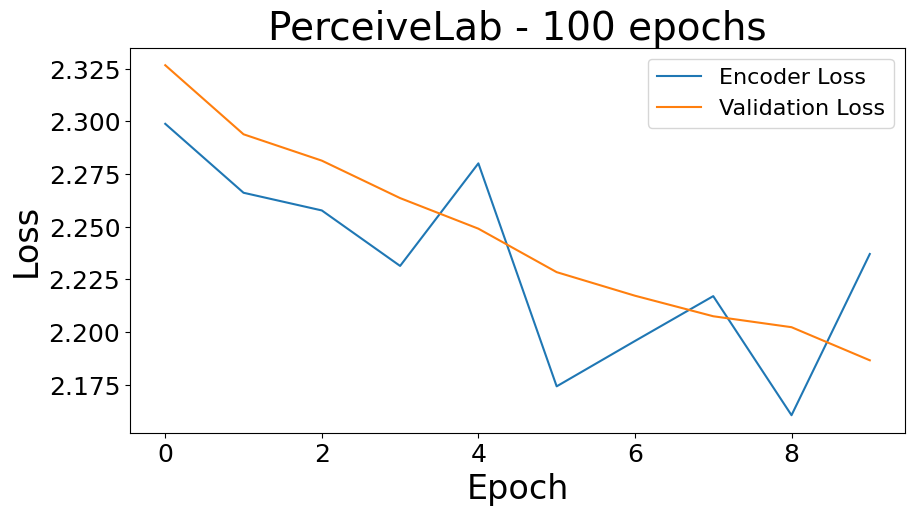

Epoch 11/100 - Training Loss: 2.1387, Validation Loss: 2.1626
Epoch 12/100 - Training Loss: 2.1583, Validation Loss: 2.1653
Epoch 13/100 - Training Loss: 2.1756, Validation Loss: 2.1469
Epoch 14/100 - Training Loss: 2.1821, Validation Loss: 2.1432
Epoch 15/100 - Training Loss: 2.0925, Validation Loss: 2.1413
Epoch 16/100 - Training Loss: 2.1115, Validation Loss: 2.1232
Epoch 17/100 - Training Loss: 2.0478, Validation Loss: 2.1188
Epoch 18/100 - Training Loss: 2.1927, Validation Loss: 2.1307
Epoch 19/100 - Training Loss: 2.0650, Validation Loss: 2.1009
Epoch 20/100 - Training Loss: 2.1423, Validation Loss: 2.0997


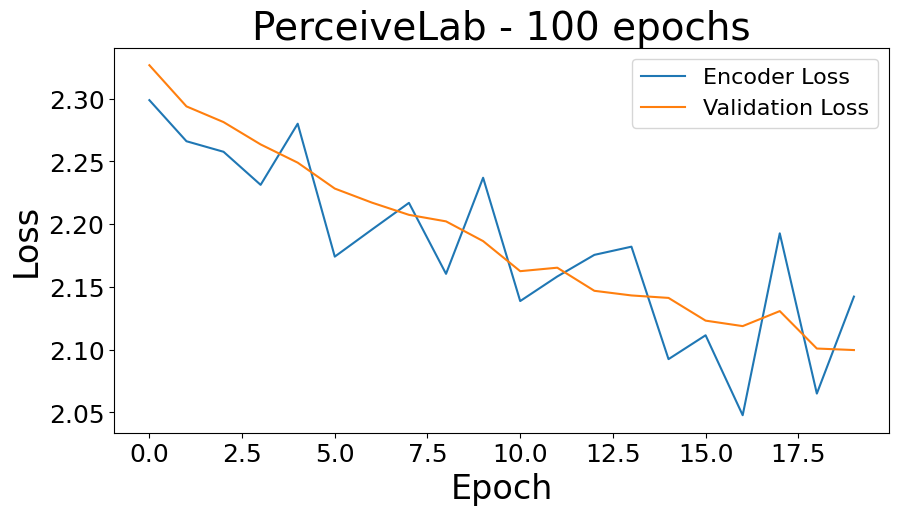

Epoch 21/100 - Training Loss: 1.9994, Validation Loss: 2.0781
Epoch 22/100 - Training Loss: 1.9714, Validation Loss: 2.0742
Epoch 23/100 - Training Loss: 2.1170, Validation Loss: 2.1026
Epoch 24/100 - Training Loss: 1.9904, Validation Loss: 2.0832
Epoch 25/100 - Training Loss: 1.9652, Validation Loss: 2.0784
Epoch 26/100 - Training Loss: 1.9590, Validation Loss: 2.0532
Epoch 27/100 - Training Loss: 1.9313, Validation Loss: 2.0807
Epoch 28/100 - Training Loss: 2.0367, Validation Loss: 2.0498
Epoch 29/100 - Training Loss: 1.9279, Validation Loss: 2.0936
Epoch 30/100 - Training Loss: 1.9287, Validation Loss: 2.0286


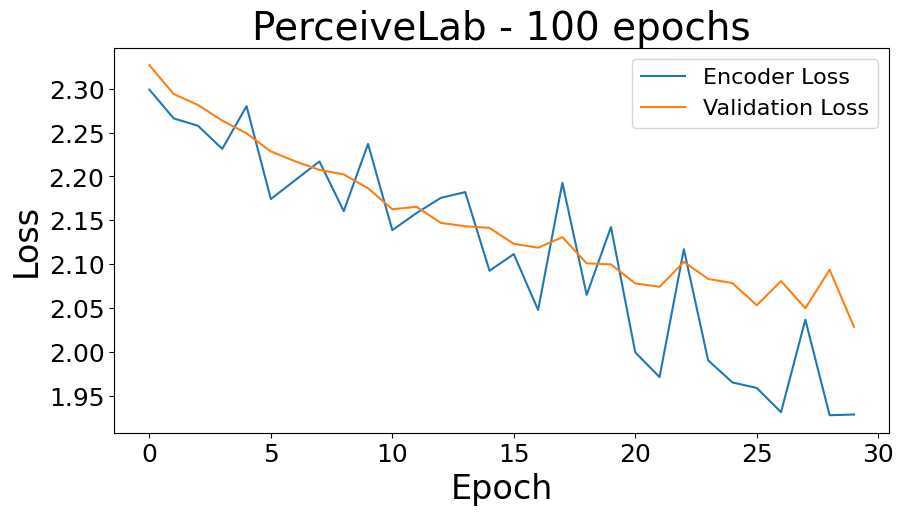

Epoch 31/100 - Training Loss: 1.9109, Validation Loss: 2.0466
Epoch 32/100 - Training Loss: 2.0773, Validation Loss: 2.0133
Epoch 33/100 - Training Loss: 1.8494, Validation Loss: 2.0200
Epoch 34/100 - Training Loss: 1.9106, Validation Loss: 2.0580
Epoch 35/100 - Training Loss: 2.0857, Validation Loss: 2.0130
Epoch 36/100 - Training Loss: 1.9093, Validation Loss: 2.0053
Epoch 37/100 - Training Loss: 1.9705, Validation Loss: 1.9959
Epoch 38/100 - Training Loss: 1.8658, Validation Loss: 1.9856
Epoch 39/100 - Training Loss: 1.8474, Validation Loss: 1.9935
Epoch 40/100 - Training Loss: 1.9040, Validation Loss: 1.9786


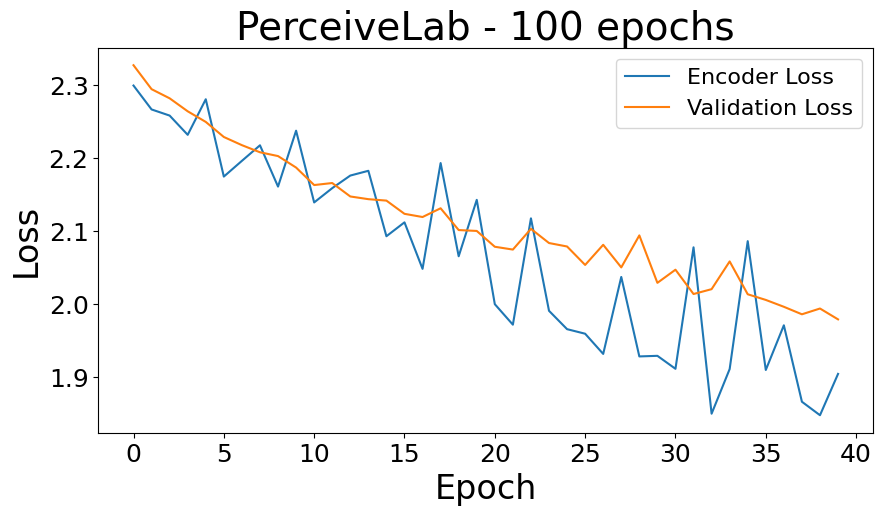

Epoch 41/100 - Training Loss: 1.9264, Validation Loss: 1.9911
Epoch 42/100 - Training Loss: 1.9648, Validation Loss: 1.9720
Epoch 43/100 - Training Loss: 1.9576, Validation Loss: 1.9641
Epoch 44/100 - Training Loss: 1.8347, Validation Loss: 1.9792
Epoch 45/100 - Training Loss: 1.9031, Validation Loss: 1.9635
Epoch 46/100 - Training Loss: 1.9404, Validation Loss: 1.9591
Epoch 47/100 - Training Loss: 1.8224, Validation Loss: 1.9860
Epoch 48/100 - Training Loss: 1.9004, Validation Loss: 1.9622
Epoch 49/100 - Training Loss: 1.8737, Validation Loss: 1.9407
Epoch 50/100 - Training Loss: 1.7517, Validation Loss: 1.9965


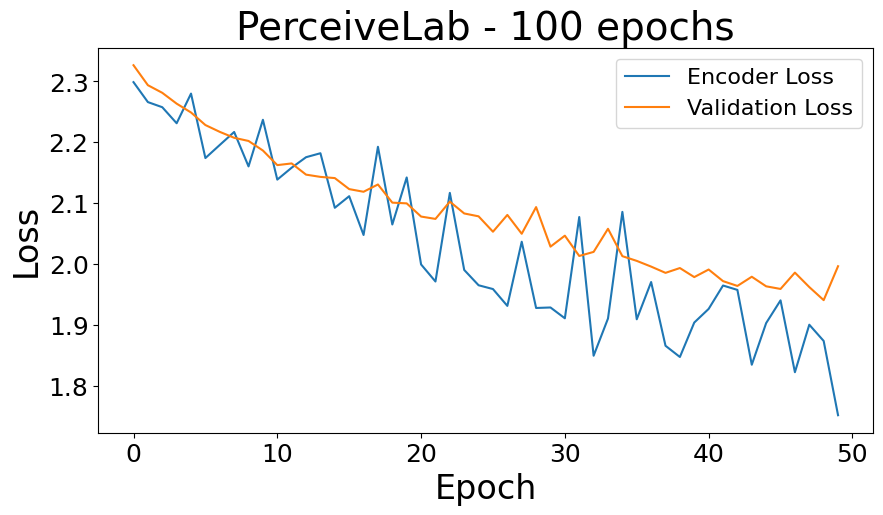

Epoch 51/100 - Training Loss: 1.8677, Validation Loss: 1.9304
Epoch 52/100 - Training Loss: 2.0043, Validation Loss: 1.9313
Epoch 53/100 - Training Loss: 1.8769, Validation Loss: 2.0094
Epoch 54/100 - Training Loss: 1.8670, Validation Loss: 1.9166
Epoch 55/100 - Training Loss: 1.8217, Validation Loss: 1.9101
Epoch 56/100 - Training Loss: 1.9297, Validation Loss: 1.9036
Epoch 57/100 - Training Loss: 1.7193, Validation Loss: 1.9046
Epoch 58/100 - Training Loss: 1.7894, Validation Loss: 1.8828
Epoch 59/100 - Training Loss: 1.8089, Validation Loss: 1.8771
Epoch 60/100 - Training Loss: 1.8632, Validation Loss: 1.8942


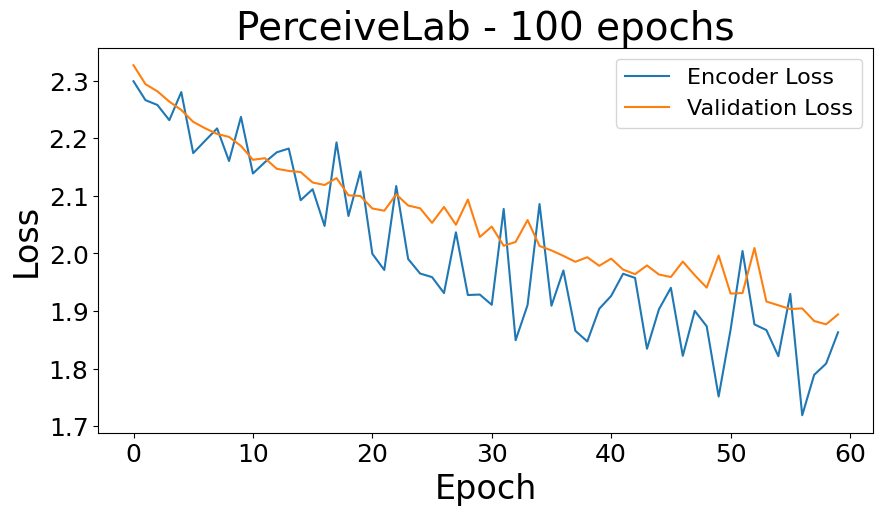

Epoch 61/100 - Training Loss: 1.7417, Validation Loss: 1.8737
Epoch 62/100 - Training Loss: 1.9693, Validation Loss: 1.9419
Epoch 63/100 - Training Loss: 1.7142, Validation Loss: 1.9345
Epoch 64/100 - Training Loss: 1.7960, Validation Loss: 1.8861
Epoch 65/100 - Training Loss: 1.7169, Validation Loss: 1.8951
Epoch 66/100 - Training Loss: 1.8489, Validation Loss: 1.9246
Epoch 67/100 - Training Loss: 1.7102, Validation Loss: 1.8399
Epoch 68/100 - Training Loss: 1.7545, Validation Loss: 1.8588
Epoch 69/100 - Training Loss: 1.7212, Validation Loss: 1.8410
Epoch 70/100 - Training Loss: 1.8642, Validation Loss: 1.8407


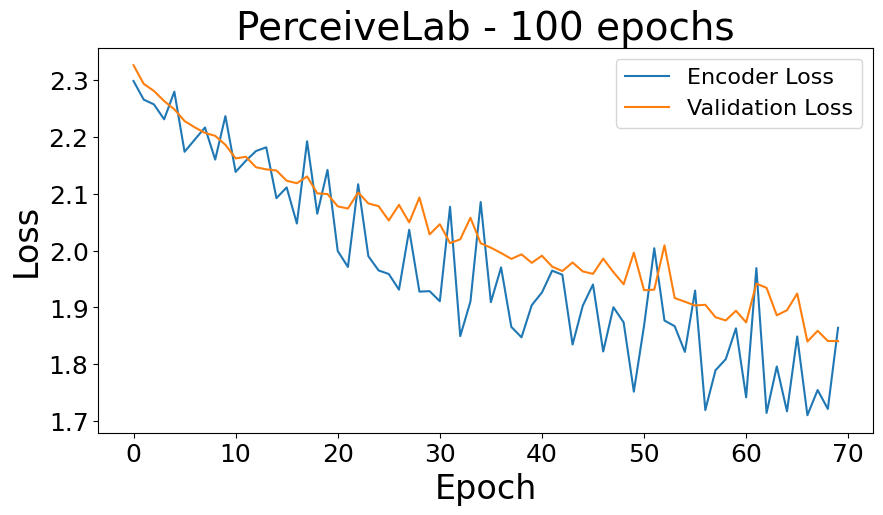

Epoch 71/100 - Training Loss: 1.7752, Validation Loss: 1.8364
Epoch 72/100 - Training Loss: 1.6735, Validation Loss: 1.8425
Epoch 73/100 - Training Loss: 1.6841, Validation Loss: 1.8454
Epoch 74/100 - Training Loss: 1.6350, Validation Loss: 1.8068
Epoch 75/100 - Training Loss: 1.6700, Validation Loss: 1.8070
Epoch 76/100 - Training Loss: 1.8711, Validation Loss: 1.8072
Epoch 77/100 - Training Loss: 1.6941, Validation Loss: 1.8310
Epoch 78/100 - Training Loss: 1.6093, Validation Loss: 1.8067
Epoch 79/100 - Training Loss: 1.7550, Validation Loss: 1.9114
Epoch 80/100 - Training Loss: 1.6866, Validation Loss: 1.8170


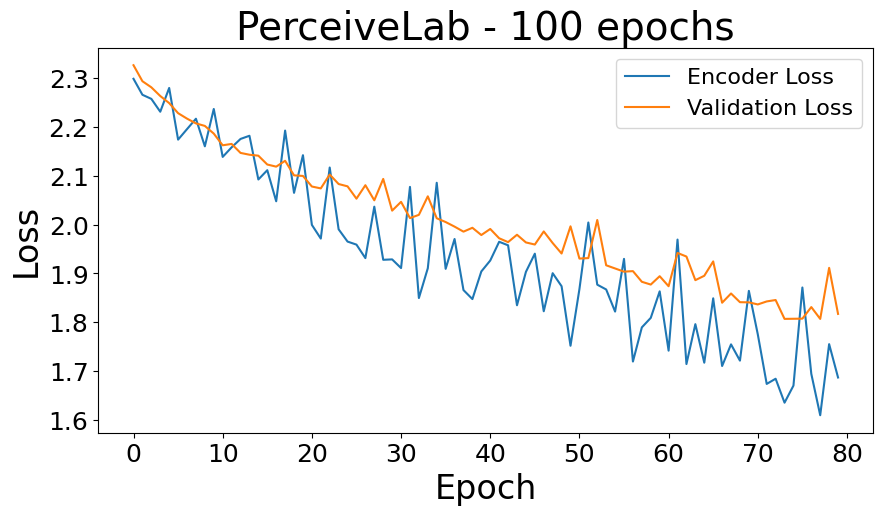

Epoch 81/100 - Training Loss: 1.7520, Validation Loss: 1.7977
Epoch 82/100 - Training Loss: 1.6423, Validation Loss: 1.7833
Epoch 83/100 - Training Loss: 1.5626, Validation Loss: 1.8819
Epoch 84/100 - Training Loss: 1.4855, Validation Loss: 1.8088
Epoch 85/100 - Training Loss: 1.7963, Validation Loss: 1.8202
Epoch 86/100 - Training Loss: 1.6949, Validation Loss: 1.7705
Epoch 87/100 - Training Loss: 1.7076, Validation Loss: 1.7759
Epoch 88/100 - Training Loss: 1.5315, Validation Loss: 1.7716
Epoch 89/100 - Training Loss: 1.5498, Validation Loss: 1.7679
Epoch 90/100 - Training Loss: 1.7440, Validation Loss: 1.8467


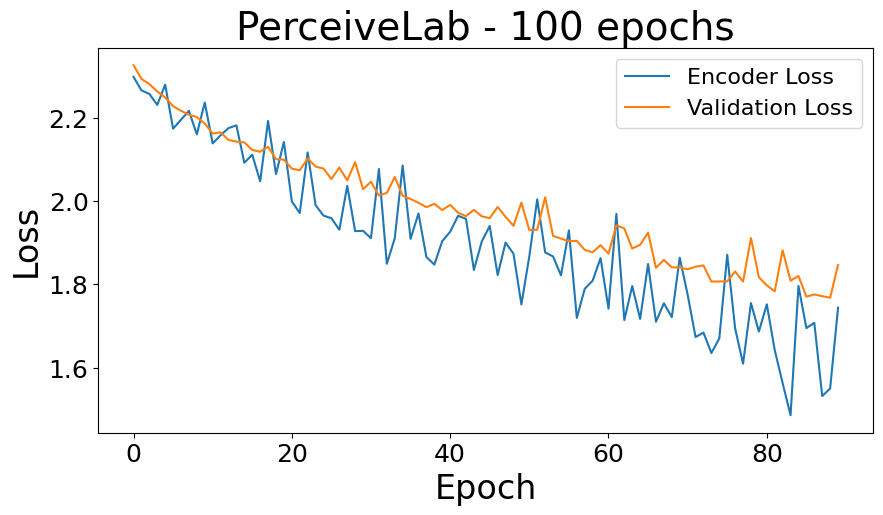

Epoch 91/100 - Training Loss: 1.7467, Validation Loss: 1.7579
Epoch 92/100 - Training Loss: 1.6820, Validation Loss: 1.7645
Epoch 93/100 - Training Loss: 1.5855, Validation Loss: 1.7472
Epoch 94/100 - Training Loss: 1.6682, Validation Loss: 1.7517
Epoch 95/100 - Training Loss: 1.6194, Validation Loss: 1.7649
Epoch 96/100 - Training Loss: 1.5964, Validation Loss: 1.7458
Epoch 97/100 - Training Loss: 1.6216, Validation Loss: 1.7551
Epoch 98/100 - Training Loss: 1.5519, Validation Loss: 1.7433
Epoch 99/100 - Training Loss: 1.5945, Validation Loss: 1.8213
Epoch 100/100 - Training Loss: 1.7923, Validation Loss: 1.7531


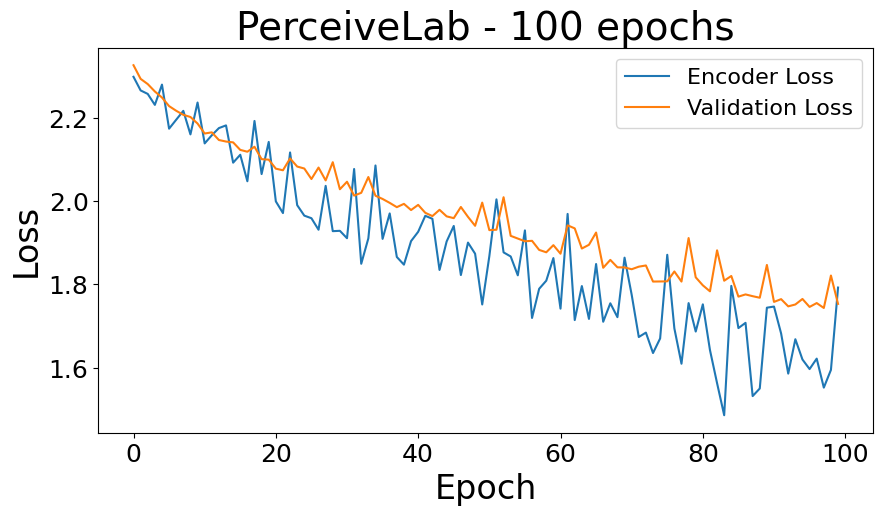

In [73]:
# Create eeg_classifier class instance based on eeg dataset origin
eeg_classifier = EEG_Classifier(eeg_origin=eeg_origin)

# Train model, specifying batch size and number of epochs
trained_model = eeg_classifier.train(model_dir='./eeg/', run_id=1, batch_size=128, num_epochs=num_epochs)

# Testing model

In [76]:
# Try model predicting data from a dataloader
def predicted_actual_classes(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for data, labels in dataloader:
            # Ensure data is on the same device as the model
            data = data.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Ensure labels are in the correct format
    # If your labels are one-hot encoded, convert them to class indices
    all_labels = [np.argmax(label) if isinstance(label, np.ndarray) else label for label in all_labels]

    return all_preds, all_labels

# Compute accuracy of model predictions based on predictions and actual labels
def compute_accuracy(predictions, actual):
    count = 0
    for i in range(len(predictions)):
        if predictions[i] == actual[i]:
            count += 1
    return count/len(predictions) * 100

# Plot a confusion matrix, visualising the model's predictions compared to the true labels
def plot_confusion_matrix(predictions, actual, num_epochs):
    fig, ax = plt.subplots(figsize=(10,10))
    cm = confusion_matrix(actual, predictions)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    plt.xlabel('Predicted class', fontsize=22)
    plt.ylabel('True class', fontsize=22)

    # Increas tick and label sizes
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)

    # Add label "Count" to colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel('Count', rotation=90, fontsize=22, labelpad=20)

    # Increase size of text inside confusion matrix
    for text in ax.texts:
        text.set_size(22)

    # Decrease margin around plot
    plt.tight_layout()

    # Set axes tick labels
    if eeg_origin == 'ThoughtViz':
        # IMAGE_CLASSES
        if tv_dataset == 'image':
            ax.set_xticklabels(['Apple', 'Car', 'Dog', 'Gold', 'Mobile', 'Rose', 'Scooter', 'Tiger', 'Wallet', 'Watch'])
            ax.set_yticklabels(['Apple', 'Car', 'Dog', 'Gold', 'Mobile', 'Rose', 'Scooter', 'Tiger', 'Wallet', 'Watch'])
            # reduce size of x tick labels
            ax.tick_params(axis='x', which='major', labelsize=14)
        # CHARACTER_CLASSES
        elif tv_dataset == 'char':
            ax.set_xticklabels(['A', 'C', 'F', 'H', 'J', 'M', 'P', 'S', 'T', 'Y'])
            ax.set_yticklabels(['A', 'C', 'F', 'H', 'J', 'M', 'P', 'S', 'T', 'Y'])
        # DIGIT_CLASSES
        elif tv_dataset == 'digit':
            ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
            ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    elif eeg_origin == 'MindBig':
        ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
        ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    elif eeg_origin == 'PerceiveLab':
        ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
        ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

    # Set title
    if eeg_origin == 'ThoughtViz':
        if tv_dataset == 'image':
            plt.title(f'{eeg_origin} (object) - {num_epochs} epochs', fontsize=28, fontweight='bold')
        else:
            plt.title(f'{eeg_origin} ({tv_dataset}) - {num_epochs} epochs', fontsize=28, fontweight='bold')
    else:
        plt.title(f'{eeg_origin} - {num_epochs} epochs', fontsize=28, fontweight='bold')

    timestamp = get_current_time()
    save_dir = './confusion_matrices/'

    # Check if the directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the directory if it does not exist

    # Save plot of loss curve. Format: loss_{eeg_origin}_{num_epochs}_{timestamp].png
    if eeg_origin == 'ThoughtViz':
        plt.savefig(os.path.join(save_dir, f'confusion_matrix_{eeg_origin}_{tv_dataset}_{num_epochs}_{timestamp}.png'), bbox_inches='tight')
    else:
        plt.savefig(os.path.join(save_dir, f'confusion_matrix_{eeg_origin}_{num_epochs}_{timestamp}.png'), bbox_inches='tight')

    plt.show()

# Try running trained model on test data
def test_trained_model(model, eeg_origin, batch_size, tv_dataset=tv_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if(eeg_origin) == 'MindBig':
        data = mb_test_dict
        x_test = np.array(data["eeg_data"])
        y_test = np.array(data["labels"])

    elif(eeg_origin) == 'ThoughtViz':
        data = tv_eeg_data
        x_test = x_test_norm
        #(data['x_test'] - np.mean(data['x_test'], axis=0)) / np.std(data['x_test'], axis=0) # Z-score normalized
        y_test = data['y_test']

    elif(eeg_origin) == 'PerceiveLab':
        x_test = prcv_test_eeg
        y_test = prcv_test_labels

    # Create tensor from training data and labels
    x_test_tensor, y_test_tensor = torch.from_numpy(x_test), torch.from_numpy(y_test)
    test_data_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
    # Create dataloader from tensor
    test_dataloader = torch.utils.data.DataLoader(test_data_tensor, batch_size, shuffle=True)

    # Plot confusion matrix and get predicted/actual classes
    predicted_classes, actual_classes = predicted_actual_classes(model, test_dataloader)
    accuracy = compute_accuracy(predicted_classes, actual_classes)
    print('Achieved accuracy:', "%.2f" % accuracy, '%')
    plot_confusion_matrix(predicted_classes, actual_classes, num_epochs)

### Load and test model

Achieved accuracy: 9.93 %


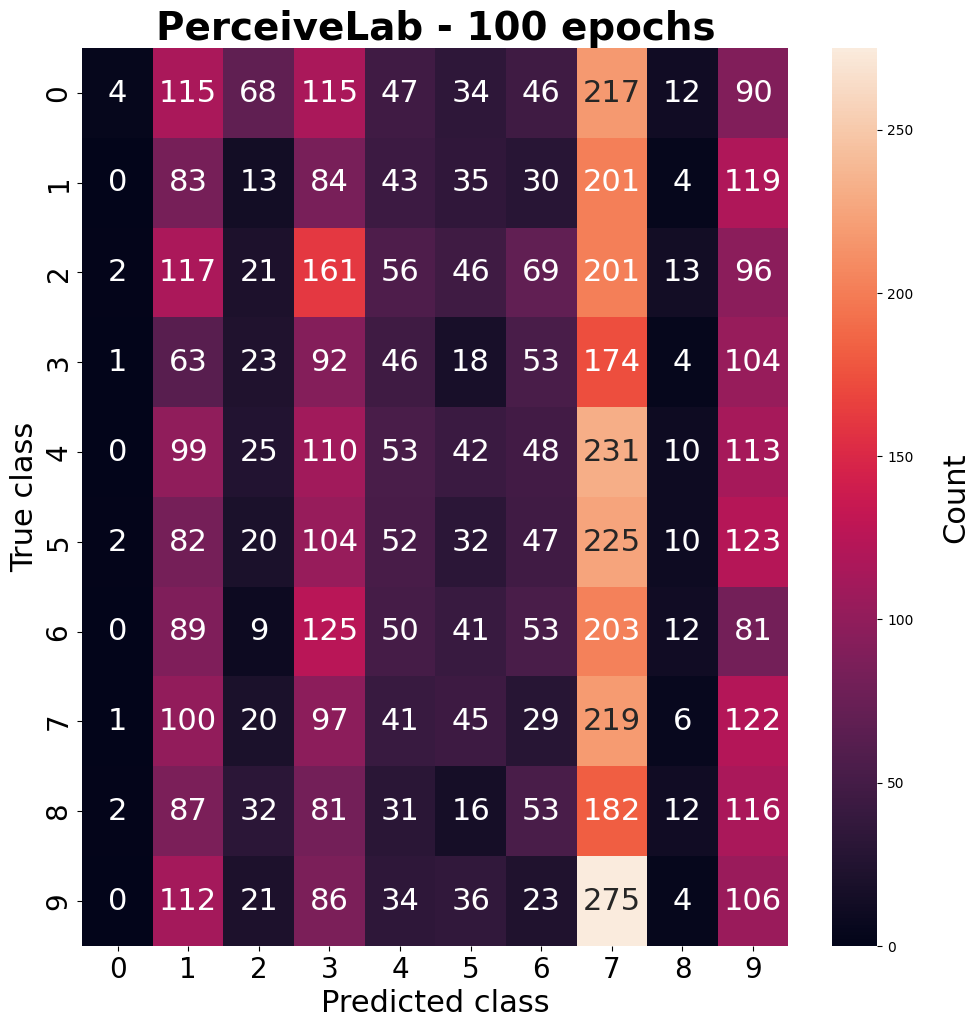

In [77]:
# Load model
channels = 14

model = EncoderModel(channels, num_classes)
model.load_state_dict(torch.load('./trained_models/PerceiveLab_100_trainedmodel_12_14_23_13_17_57.pth'))

# Test model
test_trained_model(model=model, eeg_origin=eeg_origin, batch_size=128)